In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Cargar el dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target  # Agregar la columna de etiquetas (0, 1, 2)

# Dividir en conjunto de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df['target'],
                                                    test_size=0.2, stratify=df['target'],
                                                    random_state=42)

# Verificar distribución
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} muestras ({len(X_train) / len(df) * 100:.2f}%)")
print(f"Tamaño del conjunto de prueba: {len(X_test)} muestras ({len(X_test) / len(df) * 100:.2f}%)")

print("\nDistribución en el conjunto de entrenamiento:")
print(train_counts.to_string())

print("\nDistribución en el conjunto de prueba:")
print(test_counts.to_string())


Tamaño del conjunto de entrenamiento: 120 muestras (80.00%)
Tamaño del conjunto de prueba: 30 muestras (20.00%)

Distribución en el conjunto de entrenamiento:
target
0    40
2    40
1    40

Distribución en el conjunto de prueba:
target
0    10
2    10
1    10


Para este árbol de decisión use el iris datset que contiene información sobre 150 flores iris con 4 características numéricas longitud y ancho de sépalos y pétalos y 3 clases tipos de iris. Esta la saque de la libreria sklearn. También importe los datos y los separe entre datos de entrenamiento y prueba. Luego verifiqué que se separaron correctamente e imprimí la cantidad de datos en cada clase.

In [9]:
from sklearn.linear_model import LogisticRegression

# Entrenar un modelo de regresión logística
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Obtener los coeficientes
coefficients = model.coef_

# Crear un DataFrame con los coeficientes
coef_df = pd.DataFrame(coefficients.T, index=X_train.columns, columns=['Clase 0', 'Clase 1', 'Clase 2'])

# Mostrar los coeficientes ordenados por importancia promedio
coef_df['Importancia promedio'] = coef_df.abs().mean(axis=1)
coef_df = coef_df.sort_values(by='Importancia promedio', ascending=False)

print(coef_df)


                    Clase 0   Clase 1   Clase 2  Importancia promedio
petal length (cm) -2.347304 -0.170960  2.518265              1.678843
petal width (cm)  -0.993437 -0.856124  1.849561              1.233040
sepal width (cm)   0.827323 -0.304812 -0.522511              0.551548
sepal length (cm) -0.529592  0.529720 -0.000128              0.353147


Aqui corrí una regresión logística usando la función LogisticRegression de sklearn, porque note que era la más estable para este tipo de datos. Noté que las variables más importantes fueron la de 'petal length' y 'petal width'. Ahora voy a eliminar las demás

In [12]:
# Seleccionar solo las dos variables más importantes
X_train_selected = X_train[['petal length (cm)', 'petal width (cm)']]
X_test_selected = X_test[['petal length (cm)', 'petal width (cm)']]

print(X_train_selected.head())  # Verificar que los datos quedaron bien


     petal length (cm)  petal width (cm)
8                  1.4               0.2
106                4.5               1.7
76                 4.8               1.4
9                  1.5               0.1
89                 4.0               1.3


Verificar que esta bien

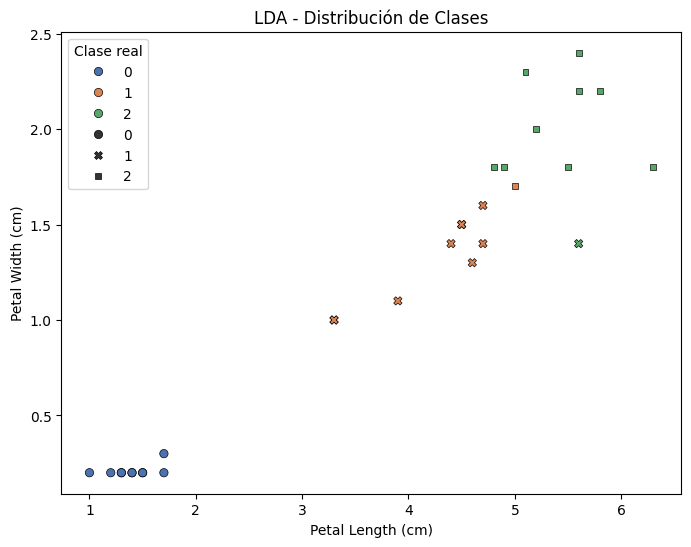

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Entrenar el modelo de LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_selected, y_train)

# Predecir valores para visualizar
y_pred_lda = lda.predict(X_test_selected)

# Graficar la función discriminante
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_selected.iloc[:, 0], y=X_test_selected.iloc[:, 1], hue=y_test, style=y_pred_lda, palette='deep', edgecolor='black')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('LDA - Distribución de Clases')
plt.legend(title='Clase real')
plt.show()


Después entrene un modelo de LDA usando las dos variables seleccionadas y grafiqué la función discriminante, mostrando cada clase con un color distinto.

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Definir valores de alpha para probar
param_grid = {'ccp_alpha': np.linspace(0, 0.02, 20)}

# Usar K-Fold con 5 folds en lugar de LOOCV
tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')  # Cambiamos a cv=5
grid_search.fit(X_train_selected, y_train)

# Mejor valor de alpha
best_alpha = grid_search.best_params_['ccp_alpha']
print(f"Mejor valor de α: {best_alpha}")

# Entrenar el árbol con el mejor alpha
pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
pruned_tree.fit(X_train_selected, y_train)


Mejor valor de α: 0.0


DecisionTreeClassifier(ccp_alpha=np.float64(0.0), random_state=42)

En este caso, no se encontró un mejor valor de alpha osea que no fue necesario una poda porque la manera en la que esta ya es la mejor posible.

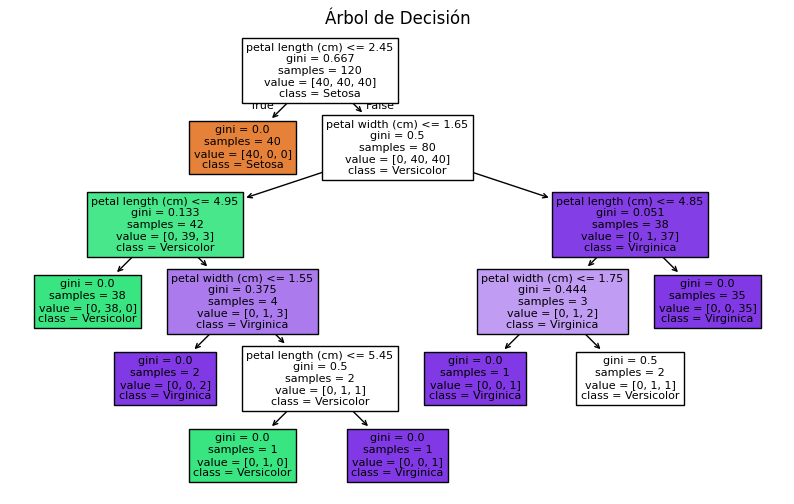

In [16]:
from sklearn.tree import plot_tree

# Graficar el árbol de decisión
plt.figure(figsize=(10, 6))
plot_tree(pruned_tree, feature_names=X_train_selected.columns, class_names=['Setosa', 'Versicolor', 'Virginica'], filled=True)
plt.title("Árbol de Decisión")
plt.show()


Aqui solamente generé el árbol de decisión de manera visual y se ve todo bien.

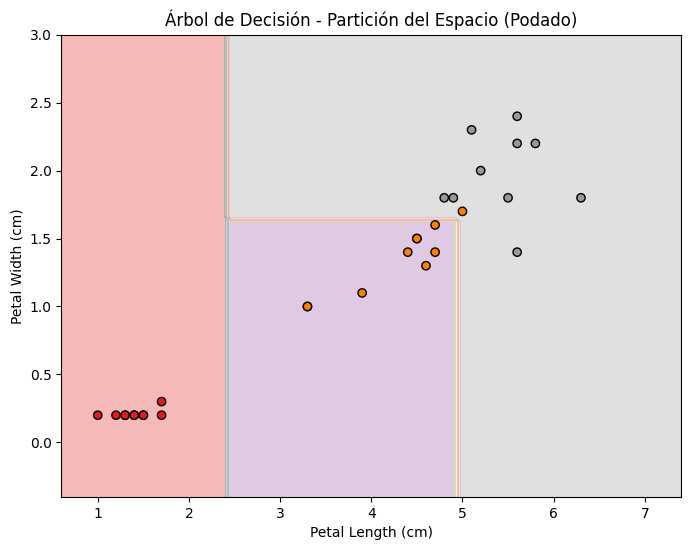

In [21]:
# Entrenar un árbol con poda manual (máxima profundidad de 3 niveles)
pruned_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
pruned_tree.fit(X_train_selected, y_train)

# Graficar la nueva partición
x_min, x_max = X_train_selected.iloc[:, 0].min() - 0.5, X_train_selected.iloc[:, 0].max() + 0.5
y_min, y_max = X_train_selected.iloc[:, 1].min() - 0.5, X_train_selected.iloc[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_train_selected.columns)
Z = pruned_tree.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')
plt.scatter(X_test_selected.iloc[:, 0], X_test_selected.iloc[:, 1], c=y_test, edgecolors='k', cmap='Set1')
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.title("Árbol de Decisión - Partición del Espacio (Podado)")
plt.show()


Aqui puse en la gráfica ya con el árbol de decisión para poder más fácilmente visualizar como los datos entran en cada clase y podemos también ver que tan preciso es. También puse una poda manual de (max_depth=3) porque se veía un poco de overfitting y asi mantengo una buena precisión sin overfitting.

In [23]:
from sklearn.metrics import accuracy_score, classification_report

# Predicciones en el conjunto de prueba
y_pred_lda = lda.predict(X_test_selected)
y_pred_tree = pruned_tree.predict(X_test_selected)

# Evaluación de LDA
print("🔹 Evaluación de LDA:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_lda):.4f}")
print(classification_report(y_test, y_pred_lda))

# Evaluación del Árbol de Decisión
print("\n🔹 Evaluación del Árbol de Decisión:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_tree):.4f}")
print(classification_report(y_test, y_pred_tree))


🔹 Evaluación de LDA:
Exactitud: 0.9333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


🔹 Evaluación del Árbol de Decisión:
Exactitud: 0.9667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Tras comparar LDA y Árbol de Decisión, encontramos que ambos modelos tienen un buen desempeño en la clasificación del conjunto de datos Iris. Sin embargo, el Árbol de Decisión podado logró una mayor exactitud (96.67%) en comparación con LDA (93.33%).